Set up and load data

1.1 Install Dependencies and set up

In [1]:
pip install tensorflow tensorflow-gpu opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\PC\imageclassification\Scripts\python.exe -m pip install --upgrade pip' command.


tensorflow - used as part of the deeplearning itself
open cv is going to be used to remove dodgy images
matplotlib is used to visualize the images

In [2]:
!pip list

Package                       Version
----------------------------- --------------------
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-client               1.9.0
anaconda-navigator            2.1.4
anaconda-project              0.10.2
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
bea

In [3]:
import tensorflow as tf
import os

os is mainly used to navigate through file structures
e.g. os.path.join('data', 'happy') go into data directory and go to a folder called happy. It is going to return a file structure that is appropriate for that particular operating system. 
os.listdir('data') - listing everything in a particular folder called data.

1.2 Removing dodgy images 

In [4]:
import cv2
import imghdr

In [5]:
data_dir='data'

In [6]:

image_exts = ['jpeg','jpg', 'bmp', 'png']

reasons for setting up data_dir extensions is to loop into every single image in a folder using os.listdir(os.path.join(data_dir, 'happy'))

In [7]:
for image_class in os.listdir(data_dir): # looping through every single one of our data directories.
    for image in os.listdir(os.path.join(data_dir, image_class)): # looping through every single subfolders and joining paths i.e. data-happy, data-sad..
        image_path = os.path.join(data_dir, image_class,  image)
        try:
            img = cv2.imread(image_path) # open the image using opencv, checks whether you can open the image using opencv.
            tip = imghdr.what(image_path) 
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)
        

1.3 Load Data

In [8]:
tf.data.Dataset
# tensorflow has a dataset API. Allows you to build a data pipeline(s) which allows you to scale out to larger datasets and gives you a repeatable set of steps that you can use.

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')
# building our data pipeline

Found 171 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()
# this allows us to loop through our data pipeline

In [12]:
batch = data_iterator.next()
# can get consequtive batches using the next method

In [13]:
# images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [14]:
# the labels. class 1 is sad people and class 0 is happy people
batch[1]

array([0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1])

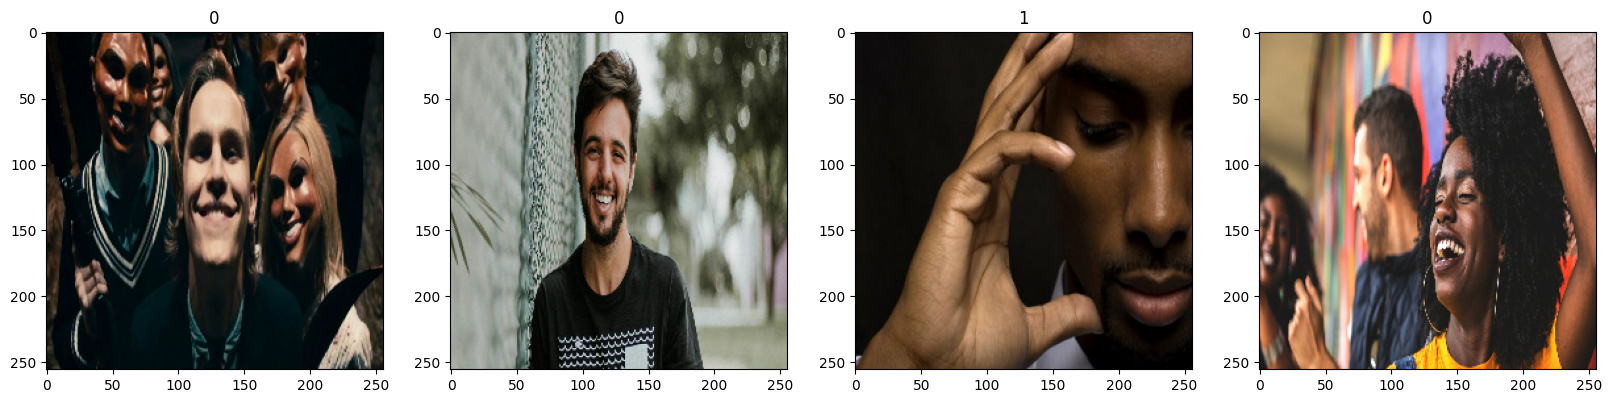

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

2. Preprocess Data

In [16]:
scaled = batch[0]/255

In [17]:
scaled.max()

1.0

2.1 Scale Data

In [18]:
# transformation step on our data pipeline
data = data.map(lambda x,y: (x/255, y))
# perform a transformation on the image data using the map function inside the data pipeline. It speeds up how quickly we can access our data from our disk. 
# tf.data has a lot of functions you can use to transform the data. 

In [19]:
scaled_iterator = data.as_numpy_iterator()


In [20]:
batch = scaled_iterator.next()

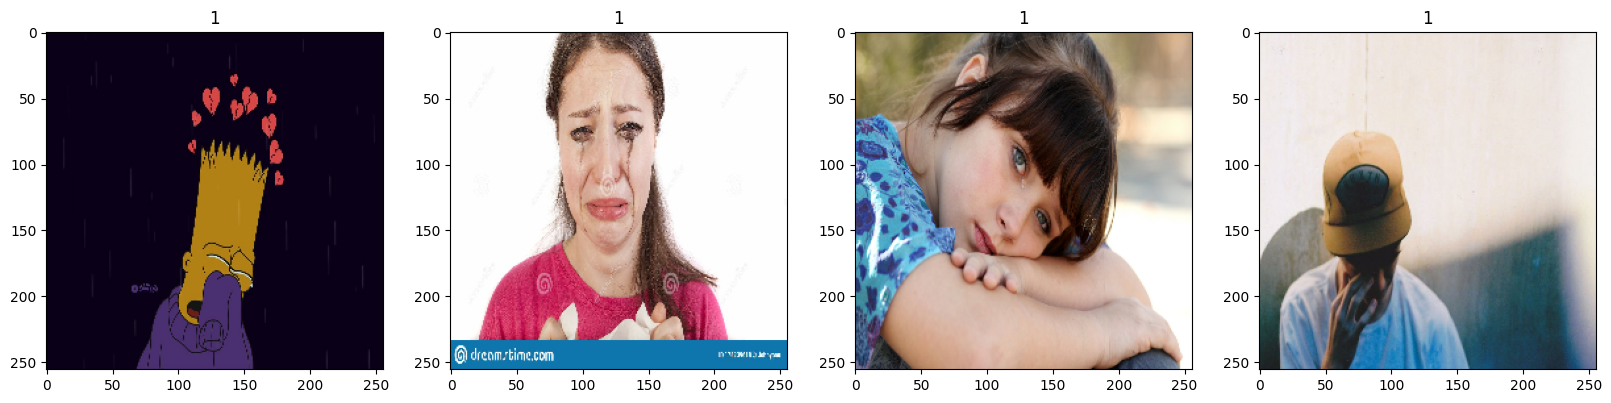

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [22]:
batch[0].min()

0.0

2.2 Split Data

In [23]:
train_size = int(len(data)*.7) # train our deep learning model
val_size = int(len(data)*.2)+1 # validate our deep learning model while its running
test_size = int(len(data)*.1)+1 # used post training to evaluate our model. 

In [24]:
train_size+val_size+test_size

7

In [25]:
# using the train and skip function inside the data pipeline in tensorflow
train = data.take(train_size) # take the 4 batches of data for training
val = data.skip(train_size).take(val_size) # first we skip the first 4 batches picked for training data,then we take  the next two batches for validation
test = data.skip(train_size+val_size).take(test_size) # take the rest which should be the test partition

In [26]:
len(test)

0

3. Deep Model


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# importing the sequential API.Sequential is great when you have one data input and one data output for the model. it is quick and easy, for deep learning classification. 
# importing layers, Conv2D, which is a 2D convolution layer (e.g. spatial convolution over images, which is what we are doing)
# MaxPooling2D acts as condensing layer, goes through your images and condenses it down.
# Dense, fully connected layer available through Keras
# Flatten, allows us to go for a convolution layer which has channels 
# Dropout for regularization
# When you are building NN, you have to form an architecture of layers or hidden layers which form the neural network

In [28]:
model = Sequential()

In [29]:
# adding our layers
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# Adding a convolution with 16 filters, and the filter will be 3 pixels by 3 pixels in size and the stride is 1. This are called architectural decisions.
# we are applying the relu activation, meaning that we are converting any negative values to zero and positive values remain unchanged. This allows us to take into account non-linear patterns. There are many activations. i.e. sigmoid activation. 
# Specify what our input shape will be, which is 256 pixels high, by 256 pixels wide, by 3 channels deep. 
model.add(MaxPooling2D())
# take the maximum value out of that relu activation 

model.add(Conv2D(32, (3,3), 1, activation='relu'))
# 32 filters
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
# 16 filters
model.add(MaxPooling2D())

model.add(Flatten())
# condensing the values to a single value

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Fully connected layers. 256 connected layers and coduct
# last layer will be 1 layer, single dense layer, single output and the activation will be a sigmoid function which takes any output and converts to either 0 or 1. 

In [30]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# compile, passing through an optimizer e.g. Adam (there are a ton of optimizers available)
# specifying what our loss is and in this case its a binary problem hence BinaryCrossentropy.
# metric we are tracking is accuracy to see how well our model does in classification as either 0 or 1.


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

3.2 Train

In [32]:
# create a log directory
logdir='logs'

In [33]:
# create a call back. really useful if you wanted to save your model at a particular checkpoint or do some logging.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
# fitting our model.
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
# take our training data, epochs is how long we want our model to train for, one epoch is equal to one run.
# after we have trained, we can run evaluation on our validation data. 
# see tutorial on call backs. 

Epoch 1/20
4/4 [==============================] - 8s 1s/step - loss: 0.9336 - accuracy: 0.6016 - val_loss: 0.6254 - val_accuracy: 0.7907
Epoch 2/20
4/4 [==============================] - 6s 1s/step - loss: 0.6436 - accuracy: 0.6016 - val_loss: 0.5419 - val_accuracy: 0.7442
Epoch 3/20
4/4 [==============================] - 6s 1s/step - loss: 0.5616 - accuracy: 0.6953 - val_loss: 0.3911 - val_accuracy: 0.8372
Epoch 4/20
4/4 [==============================] - 6s 1s/step - loss: 0.4866 - accuracy: 0.7500 - val_loss: 0.4013 - val_accuracy: 0.9070
Epoch 5/20
4/4 [==============================] - 6s 1s/step - loss: 0.4691 - accuracy: 0.7891 - val_loss: 0.2644 - val_accuracy: 0.8605
Epoch 6/20
4/4 [==============================] - 6s 1s/step - loss: 0.3437 - accuracy: 0.8828 - val_loss: 0.3694 - val_accuracy: 0.8837
Epoch 7/20
4/4 [==============================] - 6s 1s/step - loss: 0.3023 - accuracy: 0.8594 - val_loss: 0.1835 - val_accuracy: 0.9535
Epoch 8/20
4/4 [=========================

3.3 Plot Performance

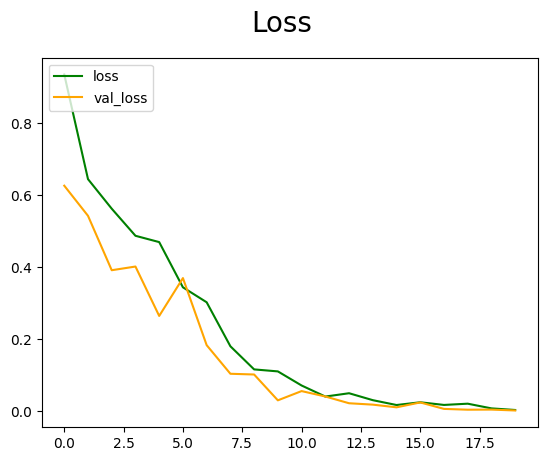

In [35]:
# plot performance of the model using matplotlib
fig = plt.figure()
plt.plot(hist.history['loss'], color='green', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

If you start to see that your loss going down and your val loss going up, it might mean that your model is overfitted and you might need to apply some regularization or you may need to change your data. 

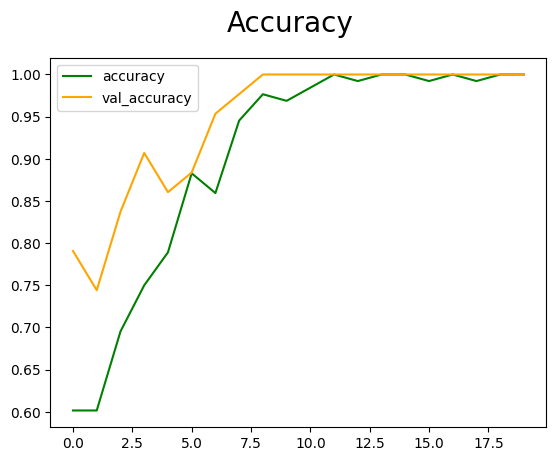

In [36]:
# visualize our accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

4. Evaluate Performance

4.1 Evaluate

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
# these are different measures that you typically use for classification problems

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

# in order to use them we need to establish instances of them. 

In [52]:
# in order to go and test them out we are going to loop them through each of our batches of data, which was only one in this case

for batch in test.as_numpy_iterator():  # bring our batch
    X, y = batch # unpack the data
    yhat = model.predict(X) # 
    pre.update_state(y, yhat) # using the update_state method to update our metrics
    re.update_state(y, yhat)
    acc.update_state(y, yhat)



In [53]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.0, Recall:0.0, Accuracy:0.0


Test

In [41]:
import cv2

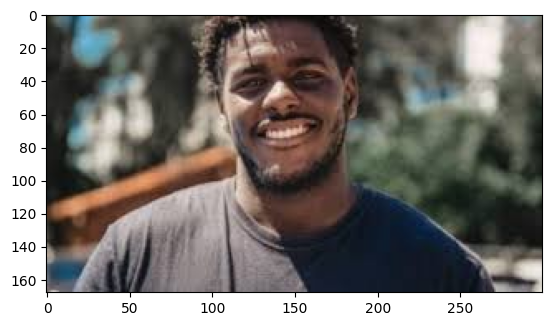

In [59]:
# use cv2 to read the test image
img = cv2.imread('happy2test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

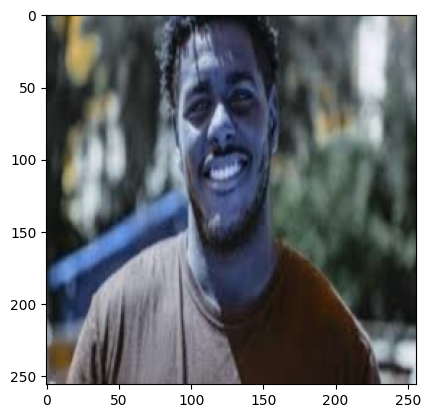

In [60]:
# In order to pass the image through our model, we need to resize it to 256 high, by 256 wide, by 3 channels as indicated earlier
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [61]:
# Our NN expects a batch of images, we therefore need to encapsulate it inside of another set of paranthesis, or arrays or list. 
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 30ms/step


In [62]:
yhat

array([[0.7587154]], dtype=float32)

In [63]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


5. Save the model

In [123]:
from tensorflow.keras.models import load_model

In [124]:
model.save(os.path.join('models','happysadclassificationmodel.h5'))

In [112]:
new_model = load_model(os.path.join('models','happysadclassificationmodel.h5'))